In [ ]:
conda info --envs

In [ ]:
conda install -c conda-forge matplotlib-venn

In [ ]:
conda install -c bioconda pybedtools

In [ ]:
conda install -c bioconda pyranges

In [9]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn2
import seaborn as sns
mpl.style.use('seaborn-white')
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooltools.expected
import cooltools.saddle
import cooler
import bbi
import cython
import os
import h5py
import re
import pybedtools
from pybedtools import bedtool
import pyranges
import itertools

In [30]:
file_name_string = 'hg38.reduced.chrom.sizes.tsv'
hg38 = pd.read_csv(file_name_string,sep='\t',index_col=0)
chromsizes = pd.read_csv(file_name_string,sep='\t',index_col=0)
chromosomes = list(chromsizes.index)

In [31]:
chromosomes

['chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY',
 'chrM']

In [32]:
# define conditions, directories and paths
dataDir = f'/home/sambares/Calico/results/coolers_library/'
outDataDir = f'/home/sambares/insulation/'
figureDir = f'{outDataDir}figures/'
conditions = [
    'hTERT-TP2-R1','hTERT-TP4-R1-1','hTERT-TP4-R1-2','hTERT-TP5-R1','hTERT-TP6-R1','PDL25-TP2-R1','PDL33-TP4-R1',
    'PDL37-TP5-R1','PD46-TP6-R1'
]

long_names = {
    'hTERT-TP2-R1':'MC-HiC-DpnII-WI38-hTERT-TP2-R1',
    'hTERT-TP4-R1-1':'MC-HiC-DpnII-WI38-hTERT-TP4-R1-1',
    'hTERT-TP4-R1-2':'MC-HiC-DpnII-WI38-hTERT-TP4-R1-2',
    'hTERT-TP5-R1':'MC-HiC-DpnII-WI38-hTERT-TP5-R1',
    'hTERT-TP6-R1':'MC-HiC-DpnII-WI38-hTERT-TP6-R1',
    'PDL25-TP2-R1':'MC-HiC-DpnII-WI38-PDL25-TP2-R1',
    'PDL33-TP4-R1':'MC-HiC-DpnII-WI38-PDL33-TP4-R1',
    'PDL37-TP5-R1':'MC-HiC-DpnII-WI38-PDL37-TP5-R1',
    'PD46-TP6-R1':'MC-HiC-DpnII-WI38-PDL46-TP6-R1',
}

In [22]:
coolersPath50kb = {}
for cond in conditions:
    coolersPath50kb[cond] = '{}{}__hg38.hg38.mapq_30.1000.mcool::resolutions/50000'.format(dataDir,long_names[cond])
    
clrs50kb = {
    cond: cooler.Cooler(coolersPath50kb[cond]) for cond in conditions
}

In [33]:
timeColors = {
    'hTERT-TP2-R1' : '#000000',
    'hTERT-TP4-R1-1' : '#00bbff',
    'hTERT-TP4-R1-2' : '#00b050',
    'hTERT-TP5-R1' : '#ffff00',
    'hTERT-TP6-R1' : '#ffc000',
    'PDL25-TP2-R1' : '#ff0000',
    'PDL33-TP4-R1' : '#a20000',
    'PDL37-TP5-R1' : '#620000',
    'PD46-TP6-R1' : '#3f0000',
}

sampleColors = {
    'hTERT-TP2-R1' : '#000000',
    'hTERT-TP4-R1-1' : '#00bbff',
    'hTERT-TP4-R1-2' : '#00b050',
    'hTERT-TP5-R1' : '#ffff00',
    'hTERT-TP6-R1' : '#ffc000',
    'PDL25-TP2-R1' : '#ff0000',
    'PDL33-TP4-R1' : '#a20000',
    'PDL37-TP5-R1' : '#620000',
    'PD46-TP6-R1' : '#3f0000',
}
groupLine = {
    'hTERT-TP2-R1' : '-',
    'hTERT-TP4-R1-1' : '-',
    'hTERT-TP4-R1-2' : '-',
    'hTERT-TP5-R1' : '-',
    'hTERT-TP6-R1' : '-',
    'PDL25-TP2-R1' : '-',
    'PDL33-TP4-R1' : '-',
    'PDL37-TP5-R1' : '-',
    'PD46-TP6-R1' : '-',
}
groupColors = {
    'hTERT-TP2-R1' : '#000000',
    'hTERT-TP4-R1-1' : '#000000',
    'hTERT-TP4-R1-2' : '#000000',
    'hTERT-TP5-R1' : '#000000',
    'hTERT-TP6-R1' : '#000000',
    'PDL25-TP2-R1' : '#000000',
    'PDL33-TP4-R1' : '#000000',
    'PDL37-TP5-R1' : '#000000',
    'PD46-TP6-R1' : '#000000',
}

In [34]:
from cooltools.insulation import _find_insulating_boundaries_dense
from cooltools.directionality import directionality

#define insulation parameters

binsize = 50000
window_bp = binsize * 5

insul = {}
direc = {}

for cond in conditions:
    # Diamond insulation score
    insul[cond] = _find_insulating_boundaries_dense(
        clrs50kb[cond], 
        balance='weight',
        window_bp=window_bp, 
        min_dist_bad_bin=2, 
    )
    
    # Directionality Index
    direc[cond] = directionality(
        clrs50kb[cond],
        window_bp=window_bp,
        min_dist_bad_bin=2,
    )

In [35]:
insul['hTERT-TP2-R1'][['chrom', 'start', 'end', 'log2_insulation_score_250000']].head()

,chrom,start,end,log2_insulation_score_250000
0,chr1,0,50000,NaN
1,chr1,50000,100000,NaN
2,chr1,100000,150000,NaN
3,chr1,150000,200000,NaN
4,chr1,200000,250000,NaN


In [36]:
direc['hTERT-TP2-R1'][['chrom', 'start', 'end', 'directionality_index_250000']].head(5000)

,chrom,start,end,directionality_index_250000
0,chr1,0,50000,NaN
1,chr1,50000,100000,NaN
2,chr1,100000,150000,NaN
3,chr1,150000,200000,NaN
4,chr1,200000,250000,NaN
...,...,...,...,...
4995,chr2,750000,800000,0.004980
4996,chr2,800000,850000,0.000103
4997,chr2,850000,900000,-0.000181
4998,chr2,900000,950000,0.000103


In [37]:
#export only relevant columns to bedgraph file before generating bigWigs

for cond in conditions:
    
    #insulation score
    insul[cond][['chrom', 'start', 'end', 'log2_insulation_score_250000']].to_csv(f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_{window_bp}.bedgraph', sep='\t', index = False, na_rep = 'nan', header = False)
    insul[cond].to_csv(f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_{window_bp}.tsv', sep='\t')
    bioframe.to_bigwig(insul[cond], hg38, 
                       f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_score_{window_bp}.bw', 
                       f'log2_insulation_score_{window_bp}')
    bioframe.to_bigwig(insul[cond], hg38, 
                       f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_pp_{window_bp}.bw', 
                       f'boundary_strength_{window_bp}')
    
    #directionality   
    direc[cond][['chrom', 'start', 'end', 'directionality_index_250000']].to_csv(f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_{window_bp}.bedgraph', sep='\t', index = False, na_rep = 'nan', header = False)
    direc[cond].to_csv(f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.direc_{window_bp}.tsv', sep='\t')
    bioframe.to_bigwig(direc[cond], hg38, 
                       f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.direc_index_{window_bp}.bw', 
                       f'directionality_index_{window_bp}')
    bioframe.to_bigwig(direc[cond], hg38, 
                       f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.direc_ratio_{window_bp}.bw', 
                       f'directionality_ratio_{window_bp}')

bedGraphToBigWig /tmp/tmpji_aja3w.bg /tmp/tmp7g8q74fl.chrom.sizes /home/sambares/insulation/MC-HiC-DpnII-WI38-hTERT-TP2-R1.50kb.insul_score_250000.bw
bedGraphToBigWig /tmp/tmpal2qetuu.bg /tmp/tmpykpphvf7.chrom.sizes /home/sambares/insulation/MC-HiC-DpnII-WI38-hTERT-TP2-R1.50kb.insul_pp_250000.bw
bedGraphToBigWig /tmp/tmpani67hrq.bg /tmp/tmpl41t7gae.chrom.sizes /home/sambares/insulation/MC-HiC-DpnII-WI38-hTERT-TP2-R1.50kb.direc_index_250000.bw
bedGraphToBigWig /tmp/tmp7f_3bsu5.bg /tmp/tmpvzzc_gqd.chrom.sizes /home/sambares/insulation/MC-HiC-DpnII-WI38-hTERT-TP2-R1.50kb.direc_ratio_250000.bw
bedGraphToBigWig /tmp/tmpf53ofhzu.bg /tmp/tmp4vdbqejp.chrom.sizes /home/sambares/insulation/MC-HiC-DpnII-WI38-hTERT-TP4-R1-1.50kb.insul_score_250000.bw
bedGraphToBigWig /tmp/tmpsibvdyo8.bg /tmp/tmp7zd7c3wp.chrom.sizes /home/sambares/insulation/MC-HiC-DpnII-WI38-hTERT-TP4-R1-1.50kb.insul_pp_250000.bw
bedGraphToBigWig /tmp/tmp4pbrb5oc.bg /tmp/tmpwwuavzm1.chrom.sizes /home/sambares/insulation/MC-HiC-Dpn

In [38]:
#if already run insulation, can read in from txt files instead of running again
binsize = 50000
window_bp = binsize * 5

insul = {}
direc = {}

for cond in conditions:
        insul[cond] = pd.read_csv(f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_{window_bp}.tsv', sep='\t')

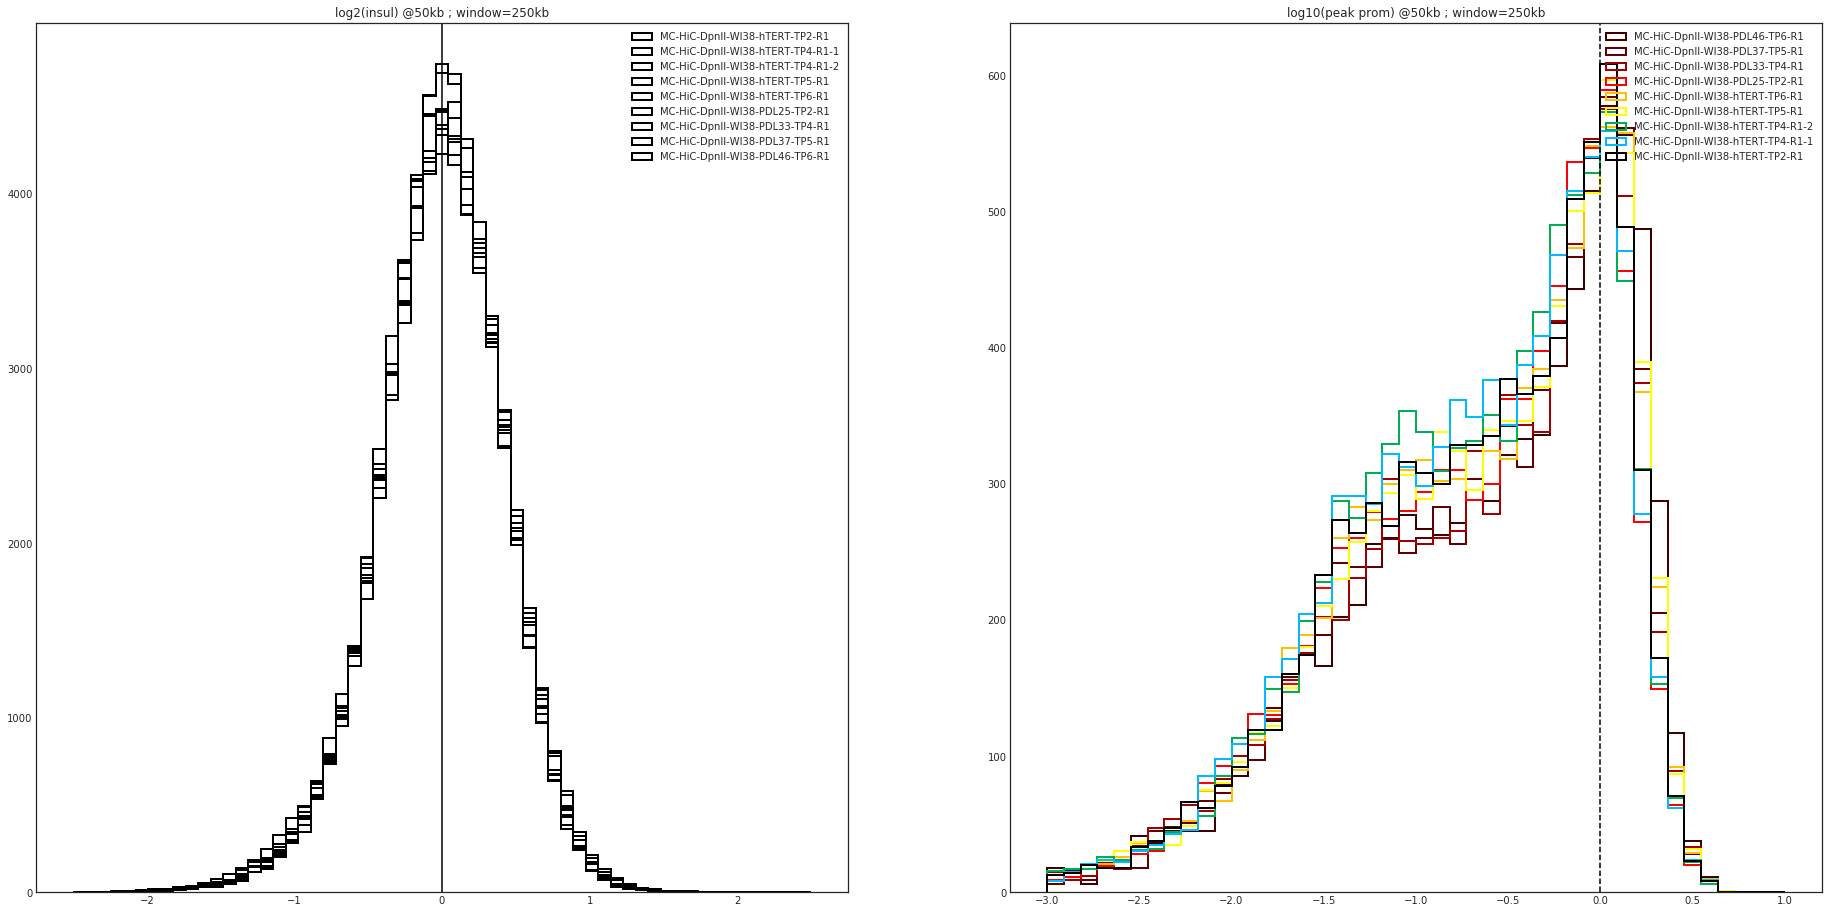

In [40]:
#Peaks analysis
gs = plt.GridSpec(nrows=1, ncols=2)
plt.figure(figsize=(16*2, 16))

binedges = np.linspace(-2.5, 2.5, 60)
plt.subplot(gs[0])
for cond in conditions:
    x = insul[cond][f'log2_insulation_score_{window_bp}'].values
    plt.hist(x[~np.isnan(x)], 
             bins=binedges, 
             histtype='step', 
             lw=2, 
             label=long_names[cond], 
             color=groupColors[cond])
plt.axvline(0, c='k', ls=groupLine[cond])
plt.legend()
plt.title(f'log2(insul) @{binsize//1000}kb ; window={window_bp//1000}kb')

plt.subplot(gs[1])
binedges = np.linspace(-3, 1, 45)
for cond in conditions[::-1]:
    x = insul[cond][f'boundary_strength_{window_bp}'].apply(np.log10).values
    plt.hist(x[~np.isnan(x)], 
             bins=binedges, 
             histtype='step', 
             lw=2,
             ls='-',
             label=long_names[cond], 
             color=sampleColors[cond])
plt.axvline(0, c='k', ls='--')
plt.legend()
plt.title(f'log10(peak prom) @{binsize//1000}kb ; window={window_bp//1000}kb')

plt.savefig(f'{figureDir}{long_names[cond]}.{binsize//1000}kb.insul_{window_bp}kb.summary.png')

In [41]:
#find peaks
peaks = {}
pscore = f'boundary_strength_{window_bp}'
cols = ['chrom', 'start', 'end', pscore]
for cond in conditions:
    peaks[cond] = (
        insul[cond].dropna(subset=[pscore])[cols]
                   .sort_values(pscore, ascending=False) # peaks!
    )
    peaks[cond].to_csv(f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.peaks_{window_bp}.tsv', sep='\t', index = False)


In [42]:
boundaryDir = f'{outDataDir}'
AsyncBounds = pd.read_csv('{}{}.{}kb.peaks_{}.tsv'.format(outDataDir, long_names[cond], binsize//1000, window_bp), sep = '\t')

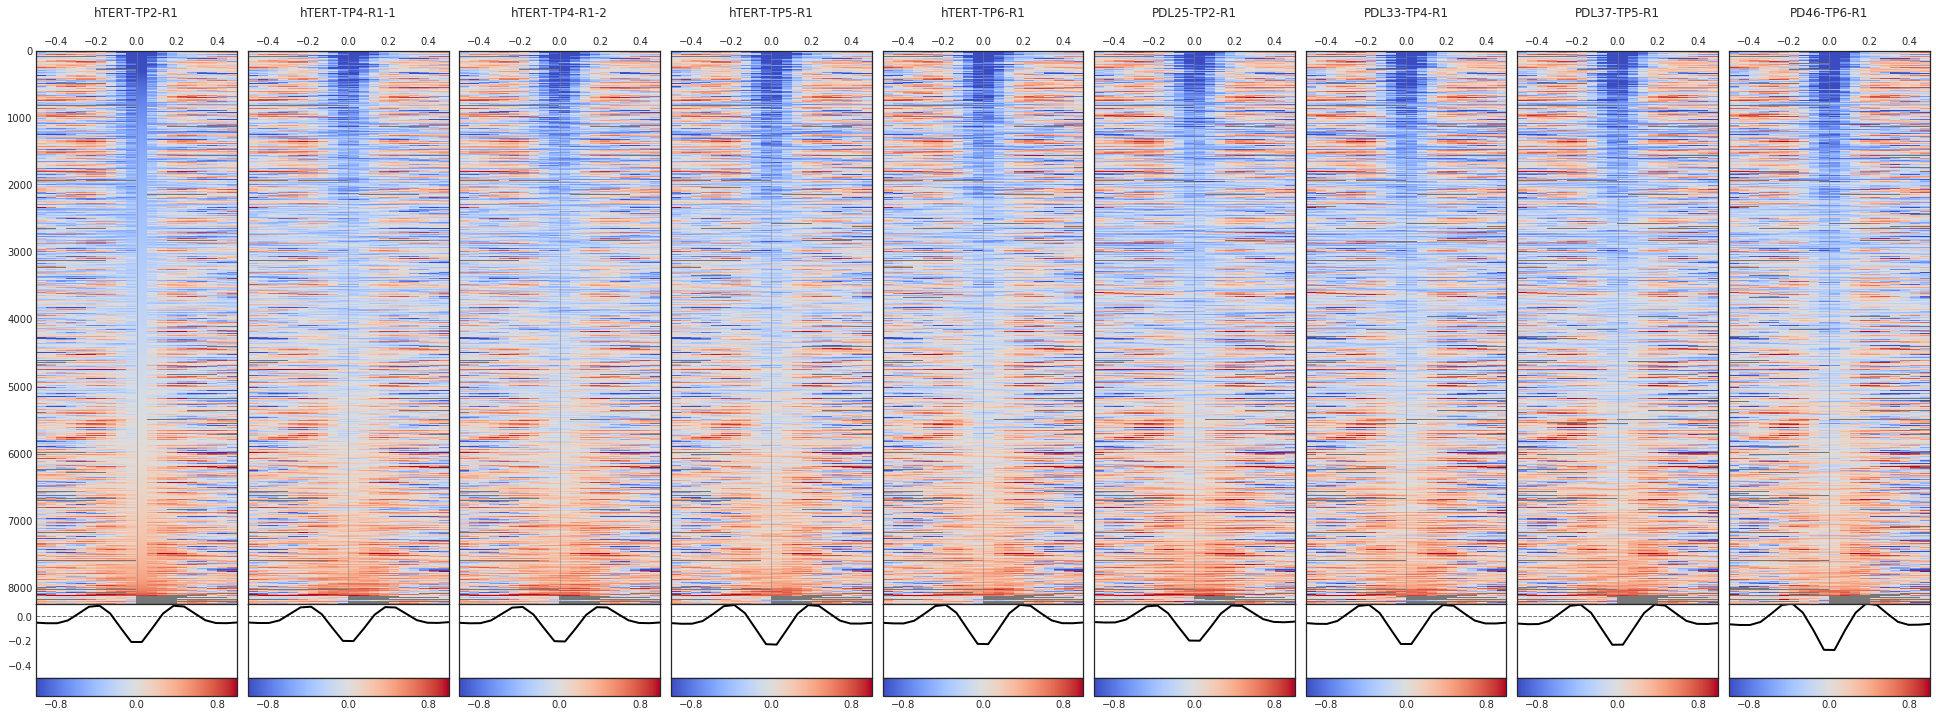

In [45]:
#plot insulation score at TAD boundaries compared to actual data
stacks = {}
for i, cond in enumerate(conditions):
    mids = (AsyncBounds['start'] + AsyncBounds['end']) // 2
    flank = 500000
    nbins = flank*2 // binsize
    bwfile = f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.insul_score_{window_bp}.bw'
    stacks[cond] = bbi.stackup(bwfile, AsyncBounds['chrom'], mids - flank, mids + flank, bins=nbins)

    
gsIns = plt.GridSpec(nrows=3, ncols=len(conditions), 
              height_ratios=[15, 2, 0.5], 
              hspace=0)

plt.figure(figsize=(3*len(conditions), 10))

X = stacks['hTERT-TP2-R1']
idx = np.argsort(X[:, X.shape[1]//2])
x = np.linspace(-flank/1e6, flank/1e6, nbins)
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad('#777777')
im_opts = dict(
    vmin=-1, 
    vmax=1,
    extent=[-flank/1e6, flank/1e6, len(AsyncBounds), 0],
    cmap=cmap
)

for i, name in enumerate(stacks):
    # heatmap
    ax = ax1 = plt.subplot(gsIns[0, i])
    X = stacks[name]
    img = ax.matshow(X[idx, :], **im_opts, rasterized=True)
    ax.axvline(0, c='grey', lw=0.5)
    ax.grid(False)
    ax.set_aspect('auto')
    ax.set_title(name)
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # summary
    ax = plt.subplot(gsIns[1, i], sharex=ax1)    
    ax.axhline(0, c='#777777', lw=1, ls='--')
    ax.plot(x, np.nanmean(stacks[name], axis=0), c='k', lw=2)
    ax.set_xlim(-flank/1e6, flank/1e6)
    ax.xaxis.set_visible(False)
    ax.set_ylim(-.5, .1)
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # color bar
    cax = plt.subplot(gsIns[2, i])
    cb = plt.colorbar(img, cax=cax, orientation='horizontal')
    cb.locator = mpl.ticker.MaxNLocator(nbins=3)
    cb.update_ticks()
    
plt.tight_layout()
plt.savefig(f'{figureDir}insulationPileup_heatmaps_AllPeaks.png')

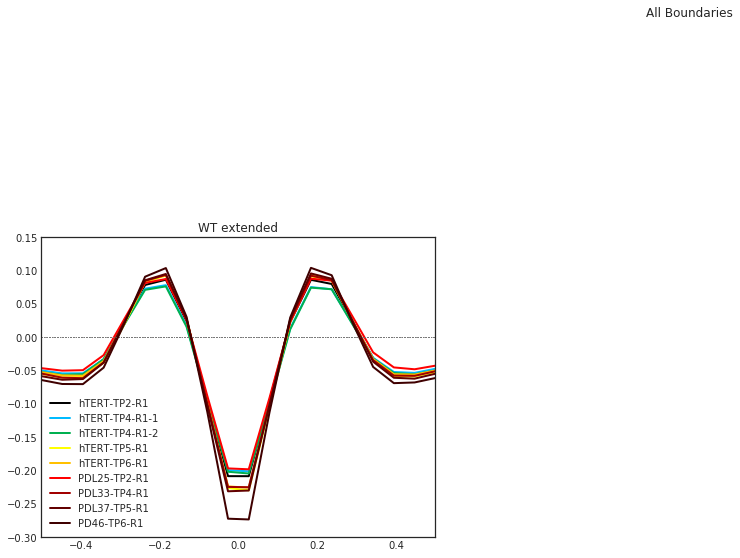

In [55]:
# Insulation
flank = 500000
binkb = 50000
nbins = flank*2 // binsize
x = np.linspace(-flank/1e6, flank/1e6, nbins)

gsIns = plt.GridSpec(nrows=5, ncols=3)
plt.figure(figsize=(24, 32))

plt.subplot(gsIns[0])
for cond in conditions[0:9]:
    plt.axhline(0, c='#777777', lw=1, ls=':')
    plt.plot(x, np.nanmean(stacks[cond], axis=0), lw=2, ls=groupLine[cond], label = cond, color=timeColors[cond])
    plt.xlim(-flank/1e6, flank/1e6)
    plt.ylim(-.3, .15)
    plt.legend()
    plt.title('WT extended')      
   
    
plt.suptitle('All Boundaries')
plt.savefig('{}All.insulationPileup_lineplots.png'.format(figureDir), dpi = 300)

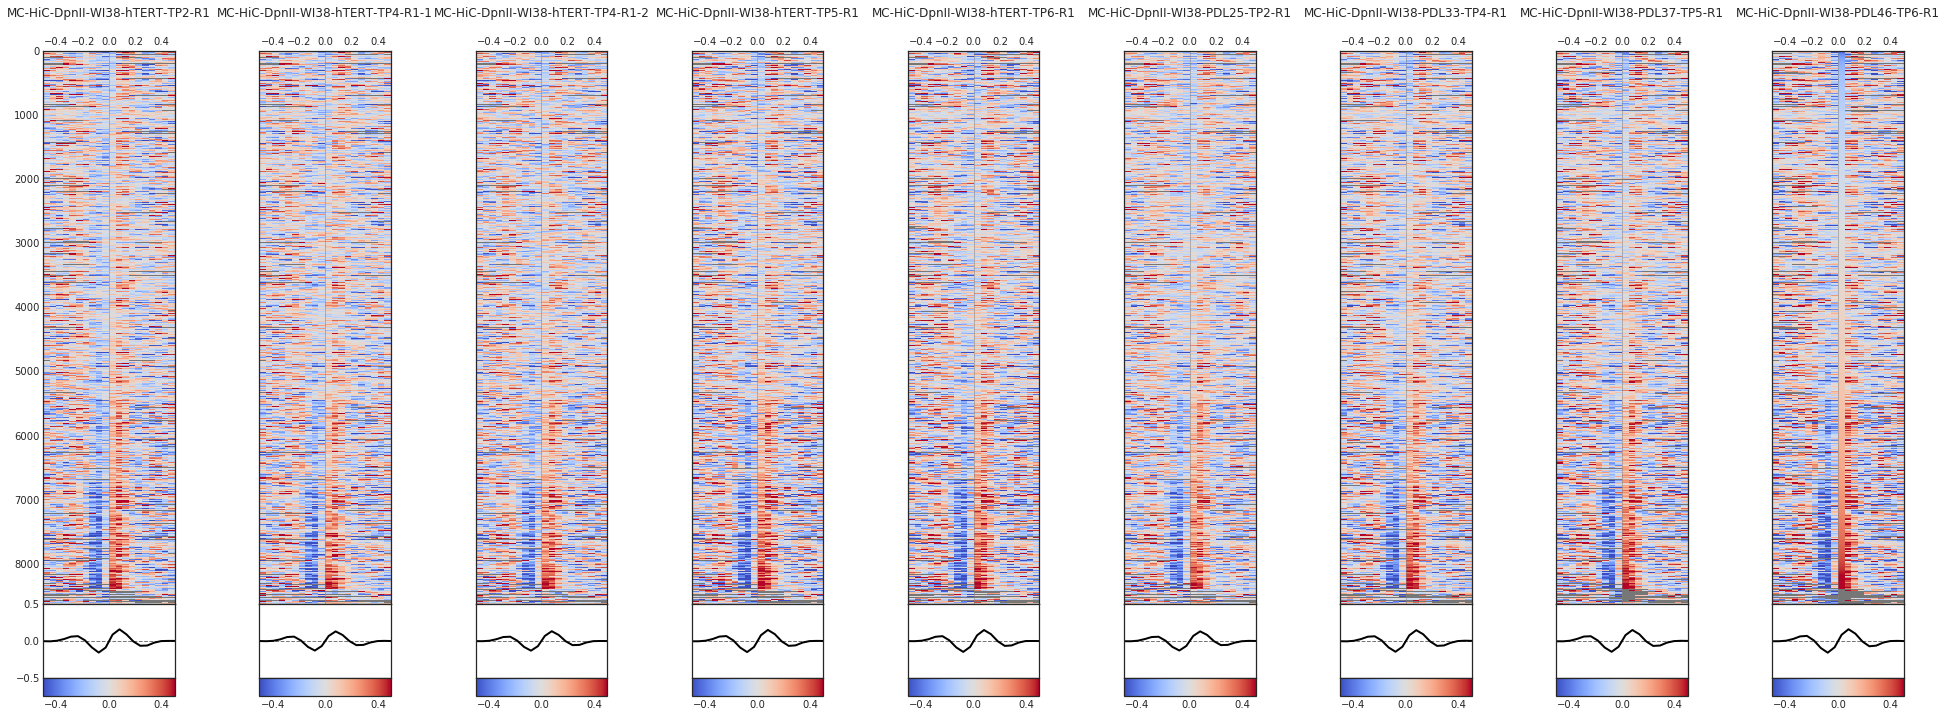

In [56]:
stacks = {}
nbins = flank*2 // binsize
wt_peaks = peaks['hTERT-TP2-R1']

for i, cond in enumerate(conditions):
    mids = (wt_peaks['start'] + wt_peaks['end']) // 2
    flank = 500000
    bwfile = f'{outDataDir}{long_names[cond]}.{binsize//1000}kb.direc_ratio_{window_bp}.bw'
    stacks[cond] = bbi.stackup(bwfile, wt_peaks['chrom'], mids - flank, mids + flank, bins=nbins)

    
gsDir = GridSpec(nrows=3, ncols=len(conditions), 
              height_ratios=[15, 2, 0.5], 
              hspace=0)

plt.figure(figsize=(3*len(conditions), 10))

X = stacks[name]
idx = np.argsort(X[:, X.shape[1]//2])
x = np.linspace(-flank/1e6, flank/1e6, nbins)
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad('#777777')
im_opts = dict(
    vmin=-0.5, 
    vmax=0.5,
    extent=[-flank/1e6, flank/1e6, len(wt_peaks), 0],
    cmap=cmap
)

for i, name in enumerate(stacks):
    # heatmap
    ax = ax1 = plt.subplot(gsDir[0, i])
    X = stacks[name]
    img = ax.matshow(X[idx, :], **im_opts, rasterized=True)
    ax.axvline(0, c='grey', lw=0.5)
    ax.grid(False)
    ax.set_aspect('auto')
    ax.set_title(long_names[name])
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # summary
    ax = plt.subplot(gsDir[1, i], sharex=ax1)    
    ax.axhline(0, c='#777777', lw=1, ls='--')
    ax.plot(x, np.nanmean(stacks[name], axis=0), c='k', lw=2)
    ax.set_xlim(-flank/1e6, flank/1e6)
    ax.xaxis.set_visible(False)
    ax.set_ylim(-0.5, 0.5)
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # color bar
    cax = plt.subplot(gsDir[2, i])
    cb = plt.colorbar(img, cax=cax, orientation='horizontal')
    cb.locator = mpl.ticker.MaxNLocator(nbins=3)
    cb.update_ticks()
    
plt.tight_layout()
plt.savefig(f'{figureDir}directionalityPileup_heatmaps_AllPeaks.png')

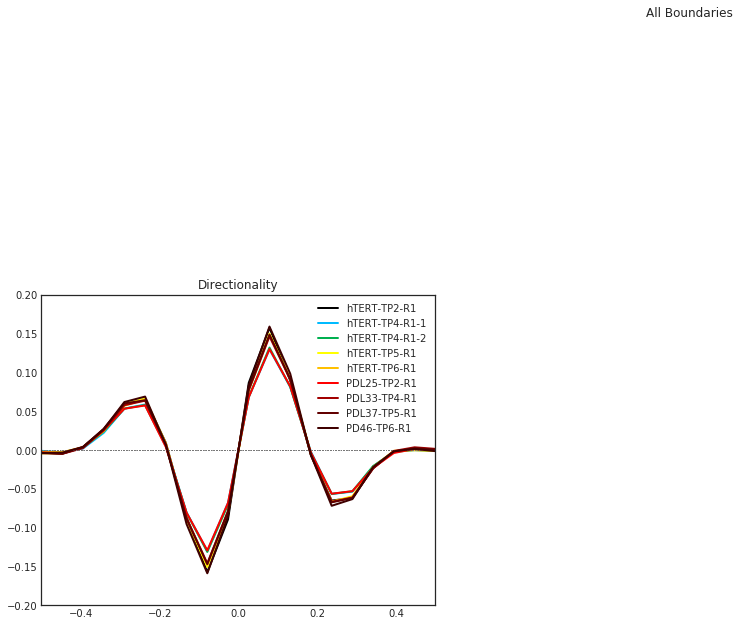

In [58]:
# Directionality
flank = 500000
binkb = 50000
nbins = flank*2 // binsize
x = np.linspace(-flank/1e6, flank/1e6, nbins)

gsDir = plt.GridSpec(nrows=6, ncols=3)
plt.figure(figsize=(24, 40))
   
plt.subplot(gsDir[0])
for cond in conditions[0:9]:
    plt.axhline(0, c='#777777', lw=1, ls=':')
    plt.plot(x, np.nanmean(stacks[cond], axis=0), lw=2, ls=groupLine[cond], label = cond, color=timeColors[cond])
    plt.xlim(-flank/1e6, flank/1e6)
    plt.ylim(-.2, .2)
    plt.legend()
    plt.title('Directionality')
   
plt.suptitle('All Boundaries')
plt.savefig('{}All.directionalityPileup_lineplots.png'.format(figureDir), dpi = 300)